In [3]:
import os 
import copy
import collections
import numpy as np 
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from pprint import pprint
import scipy.stats as stats
from scipy.stats import pearsonr
import seaborn as sns

import rdkit.Chem as Chem 
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs

import matplotlib.pyplot as plt 
from brokenaxes import brokenaxes

import torch

from utils import load_pickle, pickle_data, compute_mol_sim, compute_MS_sim, get_matched_CF

Helper Functions

In [4]:
def get_statistical_diff(helpful, harmful):

    t_statistic, two_sided_p_value = stats.ttest_ind(helpful, harmful)

    # Test if the mean of helpful is less than the mean of harmful
    _, p_val_harmful_more = stats.ttest_ind(helpful, harmful, alternative='less')

    # Test if the mean of helpful is more than the mean of harmful
    _, p_val_helpful_more = stats.ttest_ind(helpful, harmful, alternative='greater')

    return two_sided_p_value, p_val_helpful_more, p_val_harmful_more

Settings

In [5]:
model_mapping = {"binned_": "Binned \n MLP",
                 "MS_": "MS \n Transformer",
                 "formula_": "CF \n Transformer",
                 "MIST_": "MIST"}

split_mapping = {"scaffold": "Scaffold-split",
                 "inchikey": "InChIKey-split",
                 "random": "Random-split",
                 "LS": "LS-split"}

dataset_mapping = {"MSG": "MassSpecGym",
                   "NIST2023": "NIST2023"}

baseline_models_folder = "../FP_prediction/baseline_models/best_models"
mist_folder = "../FP_prediction/mist/best_models"

data_folder = Path("/data/rbg/users/klingmin/projects/MS_processing/data")
results_folder = []

for folder in [mist_folder, baseline_models_folder]:
    for dataset in os.listdir(folder):
        for checkpoint in os.listdir(os.path.join(folder, dataset)):
            if "sieved" not in checkpoint: continue
            results_folder.append(os.path.join(folder, dataset, checkpoint))

bad_color_code, good_color_code = "#A8D0DB", "#83858C"

`` Get the average percentage of training sample that are helpful / harmful ``

In [14]:
datasets = ["MSG", "NIST2023"]
models = ["binned_", "MS_", "formula_", "MIST_"] #"binned_", "MS_", "formula_", 
splits = ["scaffold", "inchikey", "random"]
score_threshold = 10.0 

for dataset in datasets:

    # Get the percentage positive and negative for identical molecules for each model and dataset 
    helpful_good_percent, helpful_bad_percent = [], []

    for split in splits: 

        for model in models: 

            results_path = [f for f in results_folder if dataset in f and model in f and split in f]
            assert len(results_path) == 1
            f = results_path[0]

            IF_scores_path = os.path.join(f, "EK-FAC_scores.pkl")
            IF_scores = load_pickle(IF_scores_path)["all_modules"]
            test_id_list = [i.replace(".ms", "").split("/")[-1].replace(".pkl", "") for i in load_pickle(os.path.join(f, "test_ids.pkl"))]
            train_id_list = [i.replace(".ms", "").split("/")[-1].replace(".pkl", "") for i in load_pickle(os.path.join(f, "train_ids.pkl"))]

            test_results = load_pickle(os.path.join(f, "test_results.pkl"))

            sorted_items = sorted(test_results.items(), key=lambda item: item[1]["loss"])
            ranking = {k: rank for rank, (k, _) in enumerate(sorted_items, start=1)}

            good_test = [k.replace(".pkl", "") for k,v in ranking.items() if v <= 100]
            bad_test = [k.replace(".pkl", "") for k,v in ranking.items() if v >= len(sorted_items) - 100]

            good_test_idx = [test_id_list.index(t) for t in good_test]
            bad_test_idx = [test_id_list.index(t) for t in bad_test]

            # Get the precentage helpful 
            print((torch.max(IF_scores[good_test_idx, :], dim = -1).values).mean())
            print((torch.max(IF_scores[bad_test_idx, :], dim = -1).values).mean())

            print((torch.min(IF_scores[good_test_idx, :], dim = -1).values).mean())
            print((torch.min(IF_scores[bad_test_idx, :], dim = -1).values).mean())

            print()

    #         a = z 
            
    #         helpful_good_percent.append((IF_scores[good_test_idx, :] > score_threshold).float().mean(-1).mean() * 100)
    #         helpful_bad_percent.append((IF_scores[bad_test_idx, :] > score_threshold).float().mean(-1).mean() * 100)

    # helpful_good_percent = np.array(helpful_good_percent).reshape(len(models), len(splits))
    # helpful_bad_percent = np.array(helpful_bad_percent).reshape(len(models), len(splits))

    a = z
    
    # # Parameters
    # bar_width = 0.35
    # bar_spacing = 1.0
    # group_spacing = 0.8
    # n_models = len(models)

    # # Compute positions
    # x_positions = []
    # model_labels = []
    # dataset_boundaries = []

    # for d_idx, dataset in enumerate(datasets):
    #     group_start = d_idx * (n_models * bar_spacing + group_spacing)
    #     group_centers = []

    #     for m_idx, model in enumerate(models):
    #         center = group_start + m_idx * bar_spacing + (bar_width / 2)
    #         x_positions.append(center)
    #         model_labels.append(model_mapping[model])
    #         group_centers.append(center)

    #     dataset_boundaries.append(np.mean(group_centers))

tensor(689.4519)
tensor(5852.7871)
tensor(-67.9404)
tensor(-767.9170)

tensor(103.6591)
tensor(332.9717)
tensor(-29.8617)
tensor(-15.0599)

tensor(208.2534)
tensor(452.8098)
tensor(-58.1989)
tensor(-9.1602)

tensor(1348650.7500)
tensor(1066562.3750)
tensor(-569790.8750)
tensor(-790135.4375)

tensor(360.7744)
tensor(13504.7920)
tensor(-88.5203)
tensor(-521.0295)

tensor(271.2101)
tensor(403.6999)
tensor(-96.2496)
tensor(-14.0577)

tensor(334.8129)
tensor(448.0712)
tensor(-162.1003)
tensor(-21.0252)

tensor(626377.6250)
tensor(1280061.7500)
tensor(-464406.8438)
tensor(-1020037.6875)

tensor(2.6109)
tensor(2626.8696)
tensor(-1.4009)
tensor(-1301.6128)

tensor(12.9467)
tensor(1371.8306)
tensor(-3.6581)
tensor(-1402.4565)

tensor(9.0820)
tensor(2287.2822)
tensor(-3.4517)
tensor(-2782.7937)

tensor(178029.2656)
tensor(2097794.7500)
tensor(-114577.4375)
tensor(-1469618.3750)



NameError: name 'z' is not defined

`` Get similarity of MS for good / bad predictions ``

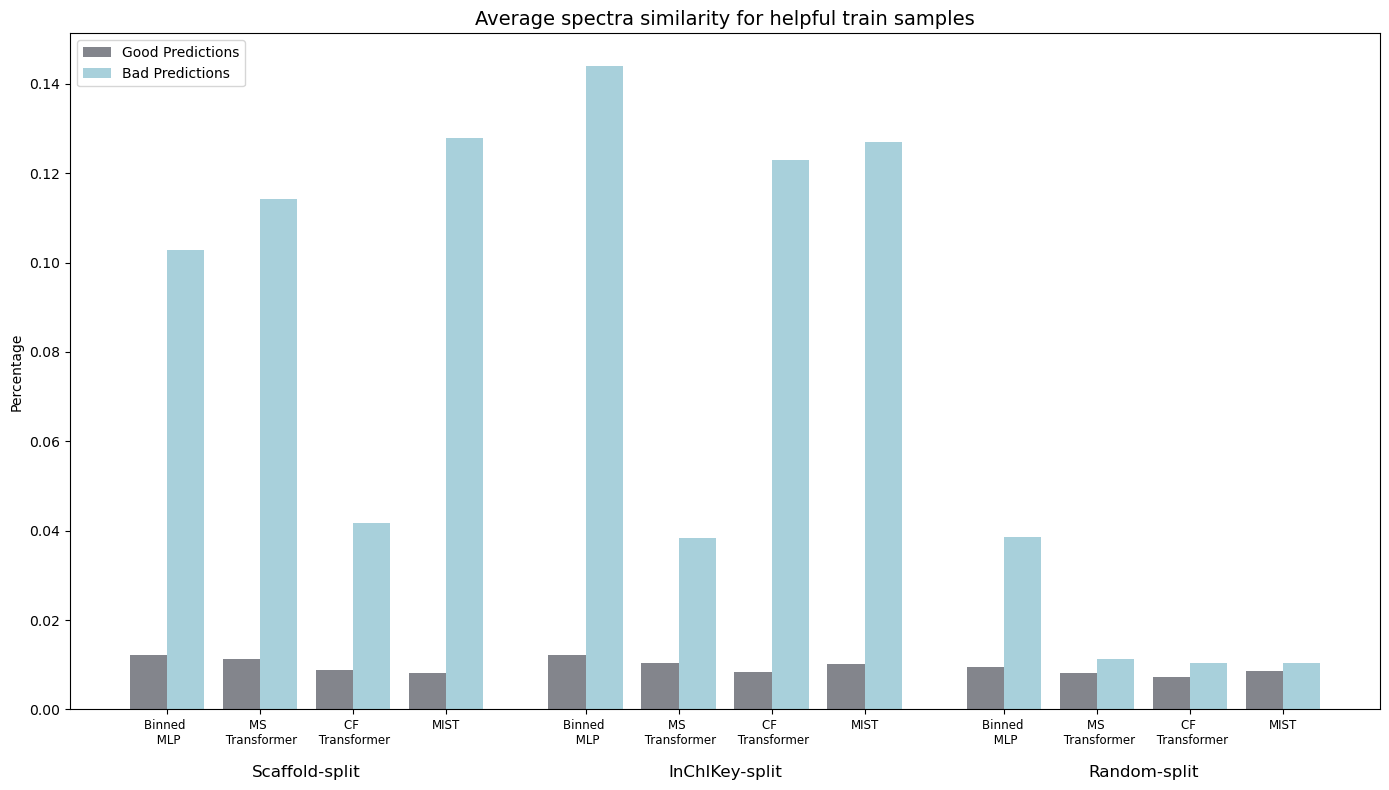

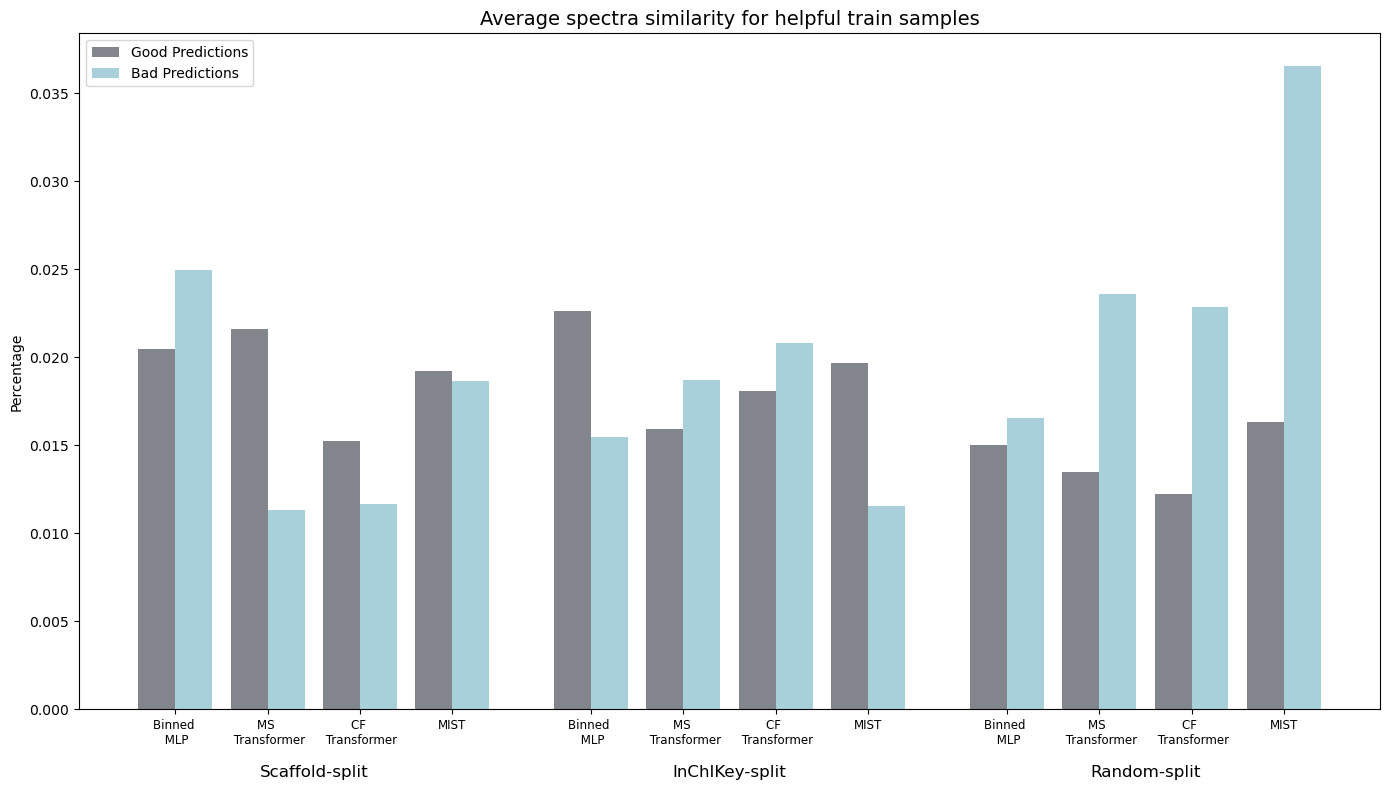

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

IF_cache_folder = "./cache/IF_results"
IF_plots_folder = os.path.join(IF_cache_folder, "IF_plots")

# Example datasets/models
models = ["binned_", "MS_", "formula_", "MIST_"]
splits = ["scaffold", "inchikey", "random"]

for dataset in ["MSG", "NIST2023"]:

    # Collect data for plotting
    good_sims = []
    bad_sims = []
    p_values = []

    for model in models:
        for split in splits: 

            f = [f for f in os.listdir(IF_cache_folder) if model in f and dataset in f and "sieved" in f and split in f][0]
            current_folder = os.path.join(IF_cache_folder, f)
            good_info_path = os.path.join(current_folder, "good_info.pkl")
            bad_info_path = os.path.join(current_folder, "bad_info.pkl")

            if not os.path.exists(good_info_path) or not os.path.exists(bad_info_path): continue

            info_good = load_pickle(good_info_path)
            info_bad = load_pickle(bad_info_path)

            # Get the average CF similarity 
            good = [r[6].item() for r in info_good]
            bad = [r[6].item() for r in info_bad]

            good_sims.append(np.mean(good))
            bad_sims.append(np.mean(bad))
            _, p_val = ttest_ind(good, bad)
            p_values.append(p_val)

    good_sims = np.array(good_sims).reshape(len(models), len(splits))
    bad_sims = np.array(bad_sims).reshape(len(models), len(splits))

    # Plot
    bar_width = 0.4
    bar_spacing = 1.0
    group_spacing = 1.5

    x_positions = []
    model_labels = [] 
    dataset_boundaries = [] 

    for s_idx, split in enumerate(splits):
        group_start = s_idx * (len(splits) * bar_spacing + group_spacing)
        group_centers = []

        for m_idx, model in enumerate(models):
            center = group_start + m_idx * bar_spacing + (bar_width / 2)
            x_positions.append(center)
            model_labels.append(model_mapping[model])
            group_centers.append(center)

        dataset_boundaries.append(np.mean(group_centers))

    # Flatten data
    good_flat = [p for group in good_sims for p in group]
    bad_flat = [n for group in bad_sims for n in group]

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))

    x_positions = np.array(x_positions)
    ax.bar(x_positions - bar_width/2, good_flat, bar_width, label='Good Predictions', color = good_color_code)
    ax.bar(x_positions + bar_width/2, bad_flat, bar_width, label='Bad Predictions', color = bad_color_code)

    # Secondary x-axis for dataset grouping
    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(dataset_boundaries)
    ax2.set_xticklabels([split_mapping[s] for s in splits])
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', length=0, pad=40, labelsize=12)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(model_labels, fontsize = 8.5)
    ax.set_ylabel('Percentage')
    ax.set_title(f'Average spectra similarity for helpful train samples', fontsize=14)
    ax.legend(loc = "upper left")

    plt.tight_layout()
    # plt.savefig(os.path.join(IF_plots_folder, f"{dataset}_CF_coverage.png"), bbox_inches='tight')

    plt.show()

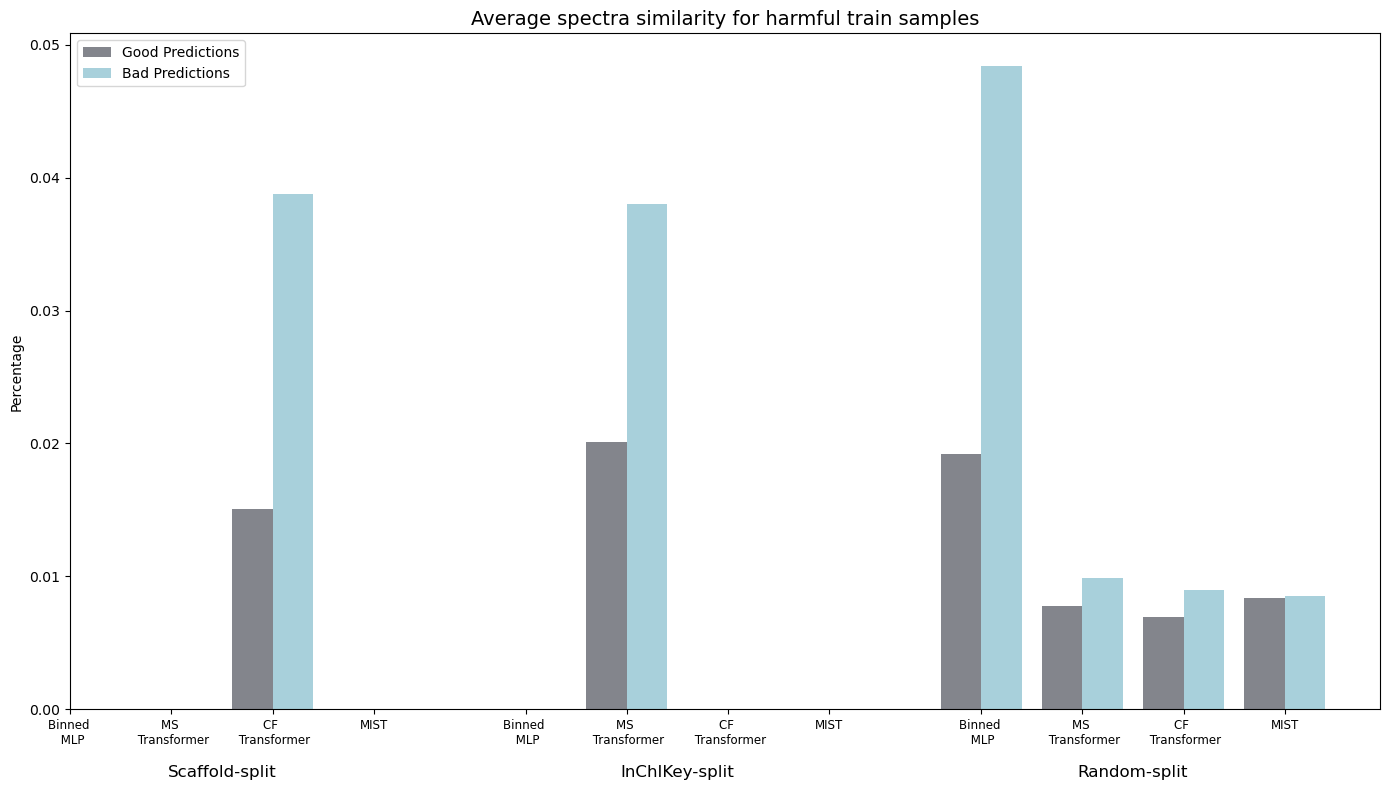

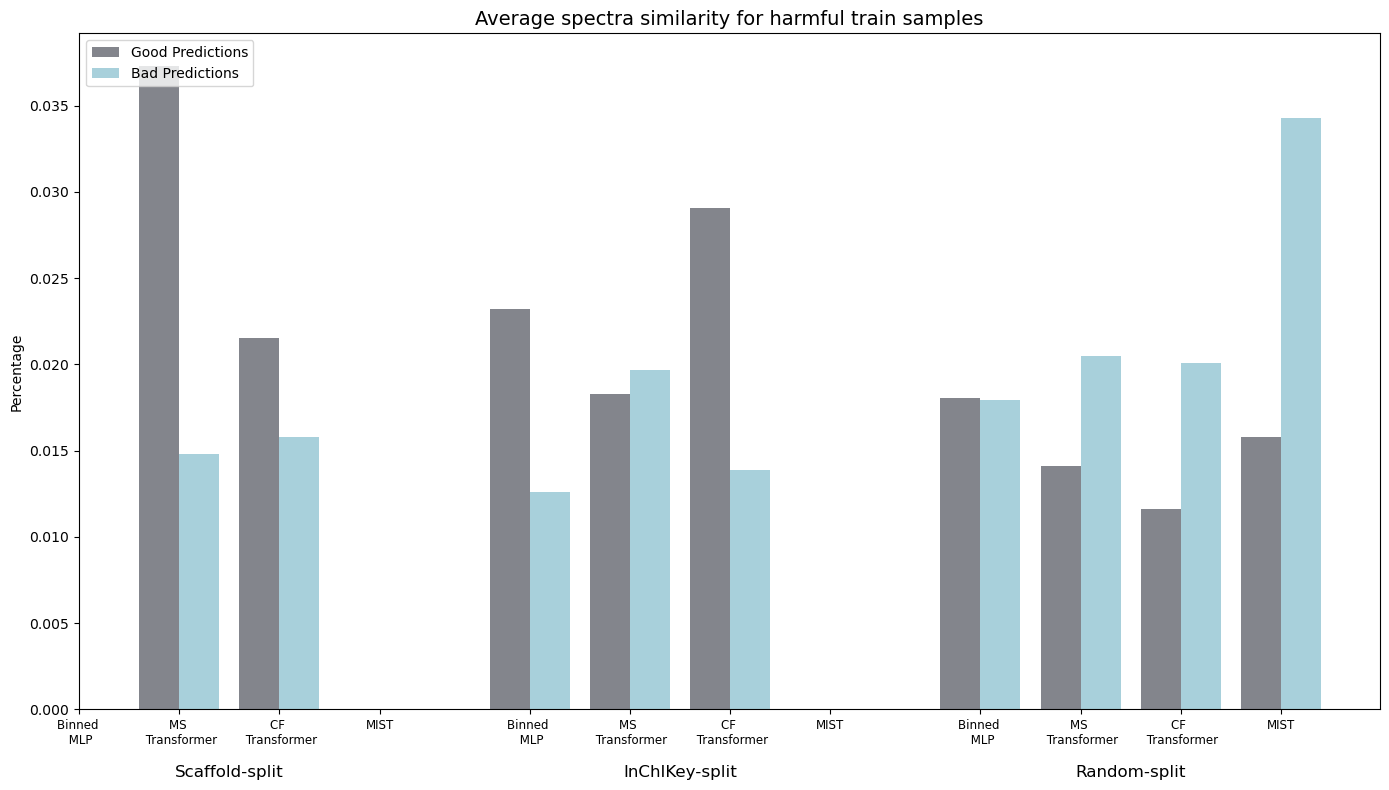

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

IF_cache_folder = "./cache/IF_results"
IF_plots_folder = os.path.join(IF_cache_folder, "IF_plots")

# Example datasets/models
models = ["binned_", "MS_", "formula_", "MIST_"]
splits = ["scaffold", "inchikey", "random"]

for dataset in ["MSG", "NIST2023"]:

    # Collect data for plotting
    good_sims = []
    bad_sims = []
    p_values = []

    for model in models:
        for split in splits: 

            f = [f for f in os.listdir(IF_cache_folder) if model in f and dataset in f and "sieved" in f and split in f][0]
            current_folder = os.path.join(IF_cache_folder, f)
            good_info_path = os.path.join(current_folder, "good_info.pkl")
            bad_info_path = os.path.join(current_folder, "bad_info.pkl")

            if not os.path.exists(good_info_path) or not os.path.exists(bad_info_path): continue

            info_good = load_pickle(good_info_path)
            info_bad = load_pickle(bad_info_path)

            # Get the average CF similarity 
            good = [r[7].item() for r in info_good]
            bad = [r[7].item() for r in info_bad]

            good_sims.append(np.mean(good))
            bad_sims.append(np.mean(bad))
            _, p_val = ttest_ind(good, bad)
            p_values.append(p_val)

    good_sims = np.array(good_sims).reshape(len(models), len(splits))
    bad_sims = np.array(bad_sims).reshape(len(models), len(splits))

    # Plot
    bar_width = 0.4
    bar_spacing = 1.0
    group_spacing = 1.5

    x_positions = []
    model_labels = [] 
    dataset_boundaries = [] 

    for s_idx, split in enumerate(splits):
        group_start = s_idx * (len(splits) * bar_spacing + group_spacing)
        group_centers = []

        for m_idx, model in enumerate(models):
            center = group_start + m_idx * bar_spacing + (bar_width / 2)
            x_positions.append(center)
            model_labels.append(model_mapping[model])
            group_centers.append(center)

        dataset_boundaries.append(np.mean(group_centers))

    # Flatten data
    good_flat = [p for group in good_sims for p in group]
    bad_flat = [n for group in bad_sims for n in group]

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))

    x_positions = np.array(x_positions)
    ax.bar(x_positions - bar_width/2, good_flat, bar_width, label='Good Predictions', color = good_color_code)
    ax.bar(x_positions + bar_width/2, bad_flat, bar_width, label='Bad Predictions', color = bad_color_code)

    # Secondary x-axis for dataset grouping
    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(dataset_boundaries)
    ax2.set_xticklabels([split_mapping[s] for s in splits])
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', length=0, pad=40, labelsize=12)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(model_labels, fontsize = 8.5)
    ax.set_ylabel('Percentage')
    ax.set_title(f'Average spectra similarity for harmful train samples', fontsize=14)
    ax.legend(loc = "upper left")

    plt.tight_layout()
    # plt.savefig(os.path.join(IF_plots_folder, f"{dataset}_CF_coverage.png"), bbox_inches='tight')

    plt.show()

In [ ]:
info_good[0]

In [ ]:
pprint(good_preds_labels)

In [ ]:
pprint(bad_preds_labels)

In [ ]:
info_good = [] 

for test_idx in range(len(good_test)):

    test_path = os.path.join(data_folder, "massspecgym", "frags_preds", good_test[test_idx])
    test_info = load_pickle(test_path)
    chosen_test_good = test_info
    test_mol = test_info["inchikey_original"][:14]
    test_idx = test_id_list.index(bad_test[test_idx])
    current_scores = IF_scores[test_idx, :]
    top_k_harmful = torch.topk(-current_scores, k = 100)
    top_k_harmful = top_k_harmful.indices

    top_k_helpful = torch.topk(current_scores, k = 100)
    top_k_helpful = top_k_helpful.indices

    mol_similarity_harmful_good = []
    MS_similarity_harmful_good = []
    CF_overlap_harmful_good = [] 

    for i, train_idx in enumerate(top_k_harmful.numpy()):

        score = IF_scores[test_idx, train_idx].item()
        if score >0: continue
        train_path = os.path.join(data_folder, "massspecgym", "frags_preds", train_id_list[train_idx])
        train_info = load_pickle(train_path)
        train_mol = train_info["inchikey_original"][:14]
        harmful_train_good = train_info

        test_smiles = test_info["smiles"]
        train_smiles = train_info["smiles"] 

        mol_similarity_harmful = compute_mol_sim(test_smiles, train_smiles)
        MS_similarity_harmful = compute_MS_sim(test_info, train_info)
        CF_overlap_harmful = get_matched_CF(test_info, train_info)
        
        mol_similarity_harmful_good.append(mol_similarity_harmful)
        MS_similarity_harmful_good.append(MS_similarity_harmful)
        CF_overlap_harmful_good.append(CF_overlap_harmful)

    mol_similarity_helpful_good = []
    MS_similarity_helpful_good = []
    CF_overlap_helpful_good = [] 

    for i, train_idx in enumerate(top_k_helpful.numpy()):

        score = IF_scores[test_idx, train_idx].item()
        if score < 0: continue
        train_path = os.path.join(data_folder, "massspecgym", "frags_preds", train_id_list[train_idx])
        train_info = load_pickle(train_path)
        train_inchikey = train_info["inchikey_original"][:14]
        helpful_train_good = train_info

        test_smiles = test_info["smiles"]
        train_smiles = train_info["smiles"] 
        
        mol_similarity_helpful = compute_mol_sim(test_smiles, train_smiles)
        MS_similarity_helpful = compute_MS_sim(test_info, train_info)
        CF_overlap_helpful = get_matched_CF(test_info, train_info)
        
        mol_similarity_helpful_good.append(mol_similarity_helpful)
        MS_similarity_helpful_good.append(MS_similarity_helpful)
        CF_overlap_helpful_good.append(CF_overlap_helpful)

    # Let us get some statistics now
    mean_mol_similarity_helpful_good = np.mean(mol_similarity_helpful_good)
    mean_mol_similarity_harmful_good = np.mean(mol_similarity_harmful_good)
    mol_similarity_diff_p_value_good_list = get_statistical_diff(mol_similarity_helpful_good, mol_similarity_harmful_good)
    mol_similarity_two_sided_p_value_good, \
    mol_similarity_one_sided_p_value_helpful_more,\
    mol_similarity_one_sided_p_value_harmful_more = mol_similarity_diff_p_value_good_list
    
    mean_MS_similarity_helpful_good = np.mean(MS_similarity_helpful_good)
    mean_MS_similarity_harmful_good = np.mean(MS_similarity_harmful_good)
    MS_similarity_diff_p_value_good_list = get_statistical_diff(MS_similarity_helpful_good, MS_similarity_harmful_good)
    MS_similarity_two_sided_p_value_good, \
    MS_similarity_one_sided_p_value_helpful_more,\
    MS_similarity_one_sided_p_value_harmful_more = MS_similarity_diff_p_value_good_list

    mean_CF_overlap_helpful_good = np.mean(CF_overlap_helpful_good)
    mean_CF_overlap_harmful_good = np.mean(CF_overlap_harmful_good)
    CF_overlap_diff_p_value_good_list = get_statistical_diff(CF_overlap_helpful_good, CF_overlap_harmful_good)
    CF_overlap_two_sided_p_value_good, \
    CF_overlap_one_sided_p_value_helpful_more,\
    CF_overlap_one_sided_p_value_harmful_more = CF_overlap_diff_p_value_good_list

    # We do some labelling now
    if mol_similarity_one_sided_p_value_harmful_more < p_value_threshold: mol_similarity_label = "harmful_more"
    elif mol_similarity_one_sided_p_value_helpful_more < p_value_threshold: mol_similarity_label = "helpful_more"
    else: mol_similarity_label = "no_diff"

    if MS_similarity_one_sided_p_value_harmful_more < p_value_threshold: MS_similarity_label = "harmful_more"
    elif MS_similarity_one_sided_p_value_helpful_more < p_value_threshold: MS_similarity_label = "helpful_more"
    else: MS_similarity_label = "no_diff"

    final_label = f"mol_{mol_similarity_label}_MS_{MS_similarity_label}"

    info_good.append([mol_similarity_label, MS_similarity_label, final_label])

info_good_df = pd.DataFrame(info_good, columns = ["mol_sim_label", "MS_sim_label", "final_label"])

#     info_good.append([mean_mol_similarity_helpful_good, mean_mol_similarity_harmful_good, mol_similarity_label, \
#                       mol_similarity_two_sided_p_value_good, mol_similarity_one_sided_p_value_helpful_more, mol_similarity_one_sided_p_value_harmful_more,\
#                       mean_MS_similarity_helpful_good, mean_MS_similarity_harmful_good, MS_similarity_label, \
#                       MS_similarity_two_sided_p_value_good, MS_similarity_one_sided_p_value_helpful_more, MS_similarity_one_sided_p_value_harmful_more,\
#                       mean_CF_overlap_helpful_good, mean_CF_overlap_harmful_good, \
#                       CF_overlap_two_sided_p_value_good, CF_overlap_one_sided_p_value_helpful_more, CF_overlap_one_sided_p_value_harmful_more])
    
# info_good_df = pd.DataFrame(info_good, columns = ["mol_sim_helpful", "mol_sim_harmful", "mol_sim_label",
#                                                   "mol_sim_2_sided_p_value", "mol_sim_1_sided_p_value_helpful_more", "mol_sim_1_sided_p_value_harmful_more",
#                                                   "MS_sim_helpful", "MS_sim_harmful", "MS_sim_label",
#                                                   "MS_sim_2_sided_p_value", "MS_sim_1_sided_p_value_helpful_more", "MS_sim_1_sided_p_value_harmful_more",
#                                                   "CF_overlap_helpful", "CF_overlap_harmful",
#                                                   "CF_overlap_2_sided_p_value", "CF_overlap_1_sided_p_value_helpful_more", "CF_overlap_1_sided_p_value_harmful_more"])


In [ ]:
info_bad = []
 
for test_idx in range(len(bad_test)):

    test_path = os.path.join(data_folder, "massspecgym", "frags_preds", bad_test[test_idx])
    test_info = load_pickle(test_path)
    test_mol = test_info["inchikey_original"][:14]
    test_idx = test_id_list.index(bad_test[test_idx])
    current_scores = IF_scores[test_idx, :]

    top_k_harmful = torch.topk(-current_scores, k = 100)
    top_k_harmful = top_k_harmful.indices

    top_k_helpful = torch.topk(current_scores, k = 100)
    top_k_helpful = top_k_helpful.indices

    mol_similarity_harmful_bad = []
    MS_similarity_harmful_bad = []
    CF_overlap_harmful_bad = [] 

    for i, train_idx in enumerate(top_k_harmful.numpy()):

        score = IF_scores[test_idx, train_idx].item()
        if score >0: continue
        train_path = os.path.join(data_folder, "massspecgym", "frags_preds", train_id_list[train_idx])
        train_info = load_pickle(train_path)
        train_mol = train_info["inchikey_original"][:14]
        harmful_train_bad = train_info

        test_smiles = test_info["smiles"]
        train_smiles = train_info["smiles"] 

        mol_similarity_harmful = compute_mol_sim(test_smiles, train_smiles)
        MS_similarity_harmful = compute_MS_sim(test_info, train_info)
        CF_overlap_harmful = get_matched_CF(test_info, train_info)

        mol_similarity_harmful_bad.append(mol_similarity_harmful)
        MS_similarity_harmful_bad.append(MS_similarity_harmful)
        CF_overlap_harmful_bad.append(CF_overlap_harmful)

    mol_similarity_helpful_bad = []
    MS_similarity_helpful_bad = []
    CF_overlap_helpful_bad = [] 

    for i, train_idx in enumerate(top_k_helpful.numpy()):

        score = IF_scores[test_idx, train_idx].item()
        if score < 0: continue
        train_path = os.path.join(data_folder, "massspecgym", "frags_preds", train_id_list[train_idx])
        train_info = load_pickle(train_path)
        train_inchikey = train_info["inchikey_original"][:14]
        helpful_train_bad = train_info

        test_smiles = test_info["smiles"]
        train_smiles = train_info["smiles"] 

        mol_similarity_helpful = compute_mol_sim(test_smiles, train_smiles)
        MS_similarity_helpful = compute_MS_sim(test_info, train_info)
        CF_overlap_helpful = get_matched_CF(test_info, train_info)
        
        mol_similarity_helpful_bad.append(mol_similarity_helpful)
        MS_similarity_helpful_bad.append(MS_similarity_helpful)
        CF_overlap_helpful_bad.append(CF_overlap_helpful)

    # Let us get some statistics now
    mean_mol_similarity_helpful_bad = np.mean(mol_similarity_helpful_bad)
    mean_mol_similarity_harmful_bad = np.mean(mol_similarity_harmful_bad)
    mol_similarity_diff_p_value_bad_list = get_statistical_diff(mol_similarity_helpful_bad, mol_similarity_harmful_bad)
    mol_similarity_two_sided_p_value_bad, \
    mol_similarity_one_sided_p_value_helpful_more,\
    mol_similarity_one_sided_p_value_harmful_more = mol_similarity_diff_p_value_bad_list
    
    mean_MS_similarity_helpful_bad = np.mean(MS_similarity_helpful_bad)
    mean_MS_similarity_harmful_bad = np.mean(MS_similarity_harmful_bad)
    MS_similarity_diff_p_value_bad_list = get_statistical_diff(MS_similarity_helpful_bad, MS_similarity_harmful_bad)
    MS_similarity_two_sided_p_value_bad, \
    MS_similarity_one_sided_p_value_helpful_more,\
    MS_similarity_one_sided_p_value_harmful_more = MS_similarity_diff_p_value_bad_list

    mean_CF_overlap_helpful_bad = np.mean(CF_overlap_helpful_bad)
    mean_CF_overlap_harmful_bad = np.mean(CF_overlap_harmful_bad)
    CF_overlap_diff_p_value_bad_list = get_statistical_diff(CF_overlap_helpful_bad, CF_overlap_harmful_bad)
    CF_overlap_two_sided_p_value_bad, \
    CF_overlap_one_sided_p_value_helpful_more,\
    CF_overlap_one_sided_p_value_harmful_more = CF_overlap_diff_p_value_bad_list

    # We do some labelling now
    if mol_similarity_one_sided_p_value_harmful_more < p_value_threshold: mol_similarity_label = "harmful_more"
    elif mol_similarity_one_sided_p_value_helpful_more < p_value_threshold: mol_similarity_label = "helpful_more"
    else: mol_similarity_label = "no_diff"

    if MS_similarity_one_sided_p_value_harmful_more < p_value_threshold: MS_similarity_label = "harmful_more"
    elif MS_similarity_one_sided_p_value_helpful_more < p_value_threshold: MS_similarity_label = "helpful_more"
    else: MS_similarity_label = "no_diff"

    final_label = f"mol_{mol_similarity_label}_MS_{MS_similarity_label}"

    info_bad.append([mol_similarity_label, MS_similarity_label, final_label])

info_bad_df = pd.DataFrame(info_bad, columns = ["mol_sim_label", "MS_sim_label", "final_label"])

#     info_bad.append([mean_mol_similarity_helpful_bad, mean_mol_similarity_harmful_bad,  mol_similarity_label, \
#                       mol_similarity_two_sided_p_value_bad, mol_similarity_one_sided_p_value_helpful_more, mol_similarity_one_sided_p_value_harmful_more,\
#                       mean_MS_similarity_helpful_bad, mean_MS_similarity_harmful_bad, MS_similarity_label, \
#                       MS_similarity_two_sided_p_value_bad, MS_similarity_one_sided_p_value_helpful_more, MS_similarity_one_sided_p_value_harmful_more,\
#                       mean_CF_overlap_helpful_bad, mean_CF_overlap_harmful_bad, \
#                       CF_overlap_two_sided_p_value_bad, CF_overlap_one_sided_p_value_helpful_more, CF_overlap_one_sided_p_value_harmful_more])
    
# info_bad_df = pd.DataFrame(info_bad, columns = ["mol_sim_helpful", "mol_sim_harmful", "mol_sim_label",
#                                                   "mol_sim_2_sided_p_value", "mol_sim_1_sided_p_value_helpful_more", "mol_sim_1_sided_p_value_harmful_more",
#                                                   "MS_sim_helpful", "MS_sim_harmful", "MS_sim_label",
#                                                   "MS_sim_2_sided_p_value", "MS_sim_1_sided_p_value_helpful_more", "MS_sim_1_sided_p_value_harmful_more",
#                                                   "CF_overlap_helpful", "CF_overlap_harmful",
#                                                   "CF_overlap_2_sided_p_value", "CF_overlap_1_sided_p_value_helpful_more", "CF_overlap_1_sided_p_value_harmful_more"])


In [ ]:
print(collections.Counter(info_good_df.loc[:, "mol_sim_label"]))
print(collections.Counter(info_good_df.loc[:, "MS_sim_label"]))
pprint(collections.Counter(info_good_df.loc[:, "final_label"]))

In [ ]:
print(collections.Counter(info_bad_df.loc[:, "mol_sim_label"]))
print(collections.Counter(info_bad_df.loc[:, "MS_sim_label"]))
pprint(collections.Counter(info_bad_df.loc[:, "final_label"]))

In [ ]:
info_bad_df

In [ ]:
print("The good records")
print() 

print("mol sim helpful: \t", info_good_df.loc[:, "mol_sim_helpful"].mean())
print("MS sim helpful: \t", info_good_df.loc[:, "MS_sim_helpful"].mean())
print("CF overlap helpful: \t", info_good_df.loc[:, "CF_overlap_helpful"].mean())

print() 

print("mol sim harmful: \t", info_good_df.loc[:, "mol_sim_harmful"].mean())
print("MS sim harmful: \t", info_good_df.loc[:, "MS_sim_harmful"].mean())
print("CF overlap harmful: \t", info_good_df.loc[:, "CF_overlap_harmful"].mean())

print()

print("The bad records")
print() 

print("mol sim helpful: \t", info_bad_df.loc[:, "mol_sim_helpful"].mean())
print("MS sim helpful: \t", info_bad_df.loc[:, "MS_sim_helpful"].mean())
print("CF overlap helpful: \t", info_bad_df.loc[:, "CF_overlap_helpful"].mean())

print()

print("mol sim harmful: \t", info_bad_df.loc[:, "mol_sim_harmful"].mean())
print("MS sim harmful: \t", info_bad_df.loc[:, "MS_sim_harmful"].mean())
print("CF overlap harmful: \t", info_bad_df.loc[:, "CF_overlap_harmful"].mean())


In [ ]:
info_good_df

In [ ]:
get_statistical_diff(info_good_df.loc[:, "MS_sim_helpful"].values, info_bad_df.loc[:, "MS_sim_helpful"].values)

`` Remarks ``

- We are almost sure that having a positive score translate to being a good training sample
    - But the magnitute seems to matter also? because there are many training samples with low MS similarity that are positive and hence deemed to be "helpful" per se... 
    - Seems like we need to take into account the magnitude of the samples;
        - Maybe we can start with having top 25 as helpful, bottom 25 as harmful and middle 50 to be neutral 

- For good predictions: 

    - Tanimoto similarity of helpful samples are characterized by lower Tanimoto similarity 
    - The MS similarity is also low 

    - Tanimoto similarity of harmful samples are characterized by higher Tanimoto similarity 
    - The MS similarity is low 

    - There is a statistical difference between the Tanimoto similarity (helpful is lower)
    - There is no statistical differences between the MS similarity (also, the MS similarity is low for both cases)

    - Therefore, this shows that the problem is that, we are trying to map things that are very different dissimilar, to similar FP

In [ ]:
print([p["mz"] for p in chosen_test_good["peaks"]])
print([p["mz"] for p in helpful_train_good["peaks"]], similarity_helpful_good, MS_similarity_helpful_good)
print([p["mz"] for p in harmful_train_good["peaks"]], similarity_harmful_good, MS_similarity_harmful_good)

In [ ]:
print([p["mz"] for p in chosen_test_bad["peaks"]])
print([p["mz"] for p in helpful_train_bad["peaks"]], similarity_helpful_bad, MS_similarity_helpful_bad)
print([p["mz"] for p in harmful_train_bad["peaks"]], similarity_harmful_bad, MS_similarity_harmful_bad)

In [ ]:
[p["mz"] for p in chosen_test_info["peaks"]]

In [ ]:
[p["mz"] for p in chosen_train_info["peaks"]]

In [ ]:
chosen_similarity